In [37]:
from pathlib import Path
from typing import Dict, Tuple, List, Iterable, Mapping, Optional, Sequence
import numpy as np
from matplotlib import pyplot as plt
from itertools import combinations

# --- Configure the runs you want to inspect ---------------------------------
RUNS_DIR = Path("/mnt/data/scastedo/runs_differential_2")
AMPAR_VALUES: List[float] = [1.0, 0.64]
RIN_VALUES: List[float] = [1.0, 1.27]
ETA_VALUES: List[float] = [0, 0.02]
TEMP_VALUES: List[float] = [0.02]
SIG_THETA_VALUES: List[float] = [0,0.05,0.1]   
IDIR_VALUES: List[float] = [0.5, 0.504, 0.505, 0.506, 0.508, 0.510, 0.515]
TRIAL_INDICES: List[int] = list(range(1))  # trial00 … trial19

# ----------------------------------------------------------------------------

def run_id(ampar: float, rin: float,sigma_temp:float, sigma_eta: float, idir: float,sigma_theta: float, trial: int) -> str:
    """Build folder name for a simulation run."""
    suffix =""# "_gain_scan_1_1" if ampar == 1.0 else "_gain_scan_063_122"
    return f"g{ampar:.3f}_rin{rin:.3f}_sigmatemp{sigma_temp:.3f}_sigmaeta{sigma_eta:.3f}_sigma_theta{sigma_theta:.3f}_idir{idir:.6f}_trial{trial:02d}{suffix}"


def load_state_matrix(folder: Path) -> np.ndarray:
    """Load a single run’s state history as neurons × generations."""
    history_file = folder / "state_history.npy"
    if not history_file.exists():
        raise FileNotFoundError(f"Missing state history file: {history_file}")
    states = np.load(history_file)  # generations × neurons
    if states.ndim != 2:
        raise ValueError(f"Expected 2‑D array in {history_file}, got {states.shape}")
    return states.T  # neurons × generations


def build_state_tensors(
    runs_dir: Path = RUNS_DIR,
    ampar_values: Iterable[float] = AMPAR_VALUES,
    rin_values: Iterable[float] = RIN_VALUES,
    eta_values: Iterable[float] = ETA_VALUES,
    temp_values: Iterable[float] = TEMP_VALUES,
    sigma_theta_values: Iterable[float] = SIG_THETA_VALUES,
    idir_values: Iterable[float] = IDIR_VALUES,
    trials: Iterable[int] = TRIAL_INDICES,
) -> Dict[Tuple[float, float, float, float, float], np.ndarray]:
    """
    Return tensors keyed by (ampar, rin, sigma_temp, sigma_eta):
      shape = (neurons, generations, trials, idir)
    """
    tensors: Dict[Tuple[float, float, float, float, float], np.ndarray] = {}
    for ampar in ampar_values:
        for rin in rin_values:
            if (ampar==1.0 and rin==1.27) or (ampar==0.64 and rin==1.0):
                continue
            for sigma_temp in temp_values:
                for sigma_eta in eta_values:
                    for sigma_theta in sigma_theta_values:
                        idir_blocks = []
                        for idir in idir_values:
                            trial_blocks = []
                            for trial in trials:
                                folder = runs_dir / run_id(ampar, rin, sigma_temp, sigma_eta, idir, sigma_theta, trial)
                                trial_blocks.append(load_state_matrix(folder))
                            trial_cube = np.stack(trial_blocks, axis=2)  # neurons × generations × trials
                            idir_blocks.append(trial_cube)
                        tensors[(ampar, rin, sigma_temp, sigma_eta, sigma_theta)] = np.stack(idir_blocks, axis=3)  # neurons × generations × trials × idir
    return tensors

In [38]:
def smooth_state(state: np.ndarray, window_size: int = 5) -> np.ndarray:
    """
    Rolling mean over generations axis (axis=1); keeps other dims.
    Expects shape (neurons, generations, trials, idir).
    """
    if window_size < 1:
        raise ValueError("window_size must be >= 1")
    cumsum = np.cumsum(state, axis=1)
    cumsum[:, window_size:] = cumsum[:, window_size:] - cumsum[:, :-window_size]
    return cumsum[:, window_size - 1:] / window_size

def compute_snr_per_mode(
    state: np.ndarray,
    idir_1: float,
    idir_2: float,
    ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute per-trial/per-angle SNR and eigenvalues.
    state shape: (neurons, generations, trials, idir)
    idir_values: iterable of idir values aligned with the last dim of `state`.
    Returns:
      snr_per_mode: trials × neurons × idir
      evals_per_mode: trials × neurons × idir
    """
    neurons, _, trials, idirs = state.shape

    snr_per_mode = np.zeros((trials, neurons))
    evals_per_mode = np.zeros((trials, neurons))
    angle =  np.flatnonzero(np.isclose(IDIR_VALUES, idir_1))[0]
    other_angle = np.flatnonzero(np.isclose(IDIR_VALUES, idir_2))[0]
    for trial in range(trials):
        delta_mu = state[:, :, trial, angle].mean(axis=1) - state[:, :, trial, other_angle].mean(axis=1)
        covariance = np.cov(state[:, :, trial, angle])
        evals, evecs = np.linalg.eigh(covariance)
        for k in range(evals.shape[0]):
            pc = evecs[:, k]
            signal_proj = np.dot(delta_mu, pc)  # optional: / np.linalg.norm(delta_mu)
            snr_per_mode[trial, k] = signal_proj ** 2  # optional: / evals[k]
            evals_per_mode[trial, k] = evals[k]

    return snr_per_mode, evals_per_mode


def compute_snr_per_mode2(
    state: np.ndarray,
    idir_1: float,
    idir_2: float,
    ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute per-trial/per-angle SNR and eigenvalues.
    state shape: (neurons, generations, trials, idir)
    idir_values: iterable of idir values aligned with the last dim of `state`.
    Returns:
      snr_per_mode: trials × neurons × idir
      evals_per_mode: trials × neurons × idir
    """
    neurons, _, trials, idirs = state.shape
    #collapse trial onto generation axis
    state = state.reshape((neurons, -1, idirs))
    snr_per_mode = np.zeros(( neurons))
    evals_per_mode = np.zeros((neurons))
    angle =  np.flatnonzero(np.isclose(IDIR_VALUES, idir_1))[0]
    other_angle = np.flatnonzero(np.isclose(IDIR_VALUES, idir_2))[0]
    delta_mu = state[:, :, angle].mean(axis=1) - state[:, :, other_angle].mean(axis=1)
    covariance = np.cov(state[:, :, angle])
    evals, evecs = np.linalg.eigh(covariance)

    snr_1= delta_mu.T @ np.linalg.pinv(covariance) @ delta_mu
    for k in range(evals.shape[0]):
        pc = evecs[:, k]
        signal_proj = np.dot(delta_mu, pc)  # optional: / np.linalg.norm(delta_mu)
        snr_per_mode[k] = signal_proj ** 2  # optional: / evals[k]
        evals_per_mode[k] = evals[k]

    return snr_per_mode, evals_per_mode, snr_1, delta_mu

def compute_snr_per_delta(state: np.ndarray, idir_values: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    state: (neurons, generations, trials, idir)
    idir_values: array-like of length idir
    Returns:
        deltas: (num_pairs * trials,) absolute ΔIdir for each trial/pair
        snr:    (num_pairs * trials,) δ^T C^{-1} δ for each trial/pair
    """
    neurons, _, trials, idirs = state.shape
    if len(idir_values) != idirs:
        raise ValueError("len(idir_values) must match state.shape[3]")

    # mean over generations → shape (neurons, trials, idir)
    means = state.mean(axis=1)


    deltas, snrs = [], []

    # use combinations to avoid duplicate (i, j) vs (j, i); include both if you prefer symmetry
    for idir_i, idir_j in combinations(range(idirs), 2):
        delta_idir = abs(idir_values[idir_i] - idir_values[idir_j])
        delta_mu = means[:, :, idir_i] - means[:, :, idir_j]  # (neurons, trials)

        for trial in range(trials):
            try:
                evals, evecs = np.linalg.eigh(np.cov(state[:, :, trial, idir_i], ddof=1))
                proj = evecs.T @ delta_mu[:, trial]      # (neurons,)
                snr_trial = np.sum((proj ** 2) / (evals+1e-12))
                deltas.append(delta_idir)
                snrs.append(snr_trial)
            except np.linalg.LinAlgError:
                continue

            # if you also want the symmetric direction, add this block:
            # evals_b, evecs_b = eig_cache[trial][idir_j]
            # proj_b = evecs_b.T @ (-delta_mu[:, trial])  # negative delta
            # snr_b = np.sum((proj_b ** 2) / (evals_b))
            # deltas.append(delta_idir)
            # snrs.append(snr_b)

    return np.asarray(deltas), np.asarray(snrs)


def overlap_function(tensors, ampar, rin, sigma_eta, sigma_temp, idir1, idir2,k=2, window_size=100):
    state1 = tensors[ampar, rin, sigma_temp,sigma_eta]
    # smoothed_state1 = smooth_state(state1, window_size = 100) #################################################3 WINDOW SIZE TO BE MODIFIED

    # average over every 10 generations and then save this
    average_size = window_size
    n_neurons, n_generations, n_trials, n_idir = state1.shape
    n_blocks = n_generations // average_size  # integer division
    cut = n_blocks * average_size             # how many generations to keep

    data_trimmed = state1[:, :cut, :, :]
    data_reshaped = data_trimmed.reshape(n_neurons, n_blocks, average_size, n_trials, n_idir)
    data_avg = data_reshaped.mean(axis=2)

    

    overlap, evals, snr_1, delmu = compute_snr_per_mode2(data_avg,idir_1=idir1,idir_2 = idir2)
    for _ in range(k):
        max_idx = np.argmax(evals)#, axis=1)
        evals = np.delete(evals, max_idx)#, axis=1)
        overlap = np.delete(overlap, max_idx)#, axis=1)

    # Compute means across animals
    # mean_evals = evals.mean(axis=0)
    # mean_overlap = overlap.mean(axis=0)
    # mean_evals = evals.flatten()
    # mean_overlap = overlap.flatten()
    # mask = mean_evals > 1e-10
    # mean_evals = mean_evals[mask]
    # mean_overlap = mean_overlap[mask]

    mean_evals = evals[:]
    mean_overlap = overlap[:]
    # Linear fit
    a, b = np.polyfit(mean_evals, mean_overlap, deg=1)

    # Generate smooth line
    xfit = np.linspace(mean_evals.min(), mean_evals.max(), 200)
    yfit = a * xfit + b

    return mean_evals, mean_overlap, xfit, yfit, a, b, snr_1, delmu


def snr_delta_function(tensors, ampar, rin, sigma_eta, sigma_temp):
    state1 = tensors[ampar, rin, sigma_temp,sigma_eta]
    smoothed_state1 = smooth_state(state1, window_size = 5)
    deltas, snrs = compute_snr_per_delta(smoothed_state1, np.array(IDIR_VALUES))

    unique_deltas = np.unique(deltas)
    avg_snrs = []
    error_snrs = []
    for delta in unique_deltas:
        snr_values = snrs[deltas == delta]
        avg_snrs.append(np.mean(snr_values))
        error_snrs.append(np.std(snr_values) / np.sqrt(len(snr_values)))

    return unique_deltas, np.array(avg_snrs), np.array(error_snrs)

In [39]:
tensors = build_state_tensors()

In [40]:
from scipy.stats import norm
def compute_snrs(
    state: np.ndarray,
    idir_1: float,
    idir_2: float,
    ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute per-trial/per-angle SNR and eigenvalues.
    state shape: (neurons, generations, trials, idir)
    idir_values: iterable of idir values aligned with the last dim of `state`.
    Returns:
      snr_per_mode: trials × neurons × idir
      evals_per_mode: trials × neurons × idir
    """
    state = state.reshape((state.shape[0], -1, len_trial, state.shape[3]))
    neurons, _, trials, idirs = state.shape
    snr_array = np.zeros((trials))
    for trial in range(trials):
        angle =  np.flatnonzero(np.isclose(IDIR_VALUES, idir_1))[0]
        other_angle = np.flatnonzero(np.isclose(IDIR_VALUES, idir_2))[0]
        delta_mu = state[:, :, trial,angle].mean(axis=1) - state[:, :, trial,other_angle].mean(axis=1)
        covariance = np.cov(state[:, :, trial, angle])

        snr_1= delta_mu.T @ np.linalg.pinv(covariance) @ delta_mu
        snr_array[trial] = snr_1

    return snr_array

def compute_snr_per_delta(state: np.ndarray, idir_values: np.ndarray, window_size: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    state: (neurons, generations, trials, idir)
    idir_values: array-like of length idir
    Returns:
        deltas: (num_pairs * trials,) absolute ΔIdir for each trial/pair
        snr:    (num_pairs * trials,) δ^T C^{-1} δ for each trial/pair
    """
    neurons, _, trials, idirs = state.shape
    if len(idir_values) != idirs:
        raise ValueError("len(idir_values) must match state.shape[3]")
    average_size = window_size
    n_neurons, n_generations, n_trials, n_idir = state.shape
    n_blocks = n_generations // average_size  # integer division
    cut = n_blocks * average_size             # how many generations to keep

    data_trimmed = state[:, :cut, :, :]
    data_reshaped = data_trimmed.reshape(n_neurons, n_blocks, average_size, n_trials, n_idir)
    data_avg = data_reshaped.mean(axis=2)

    deltas, snrs = [], []
    snrs = np.zeros((idirs,len_trial))
    deltas  = np.zeros((idirs))


    # use combinations to avoid duplicate (i, j) vs (j, i); include both if you prefer symmetry
    # for idir_i, idir_j in combinations(range(idirs), 2):
    #     delta_idir = abs(idir_values[idir_i] - idir_values[idir_j])
    #     deltas.append(delta_idir)
    #     snrs.append(compute_snrs(data_avg, idir_1=idir_values[idir_i], idir_2=idir_values[idir_j]))

    idir_i = 0.5
    for idir_j in range(idirs):
      
        delta_idir = abs(idir_values[idir_j] - idir_i)
        deltas[idir_j] = delta_idir
        snrs[idir_j,:] = compute_snrs(data_avg, idir_1=idir_i, idir_2=idir_values[idir_j])

    return deltas, snrs

len_trial = 1
neurons = tensors[1,1,TEMP_VALUES[0],0,0].shape[0]

delta_final_fr = np.zeros((len(TEMP_VALUES), len(ETA_VALUES),len(SIG_THETA_VALUES), len(IDIR_VALUES)))
snr_final_fr = np.zeros((len(TEMP_VALUES), len(ETA_VALUES),len(SIG_THETA_VALUES), len(IDIR_VALUES), len_trial))

delta_final_ctr = np.zeros((len(TEMP_VALUES), len(ETA_VALUES),len(SIG_THETA_VALUES),  len(IDIR_VALUES)))
snr_final_ctr = np.zeros((len(TEMP_VALUES), len(ETA_VALUES),len(SIG_THETA_VALUES), len(IDIR_VALUES), len_trial))

WINDOW = 1

for i, temp in enumerate(TEMP_VALUES):
    for j, eta in enumerate(ETA_VALUES):
        for k, sigma_theta in enumerate(SIG_THETA_VALUES):
            delta_final_fr[i,j,k,:], snr_final_fr[i,j,k,:,:] = compute_snr_per_delta(tensors[0.64,1.27,temp,eta,sigma_theta], IDIR_VALUES, window_size=WINDOW)
            delta_final_ctr[i,j,k,:], snr_final_ctr[i,j,k,:,:] = compute_snr_per_delta(tensors[1,1,temp,eta,sigma_theta], IDIR_VALUES, window_size=WINDOW)


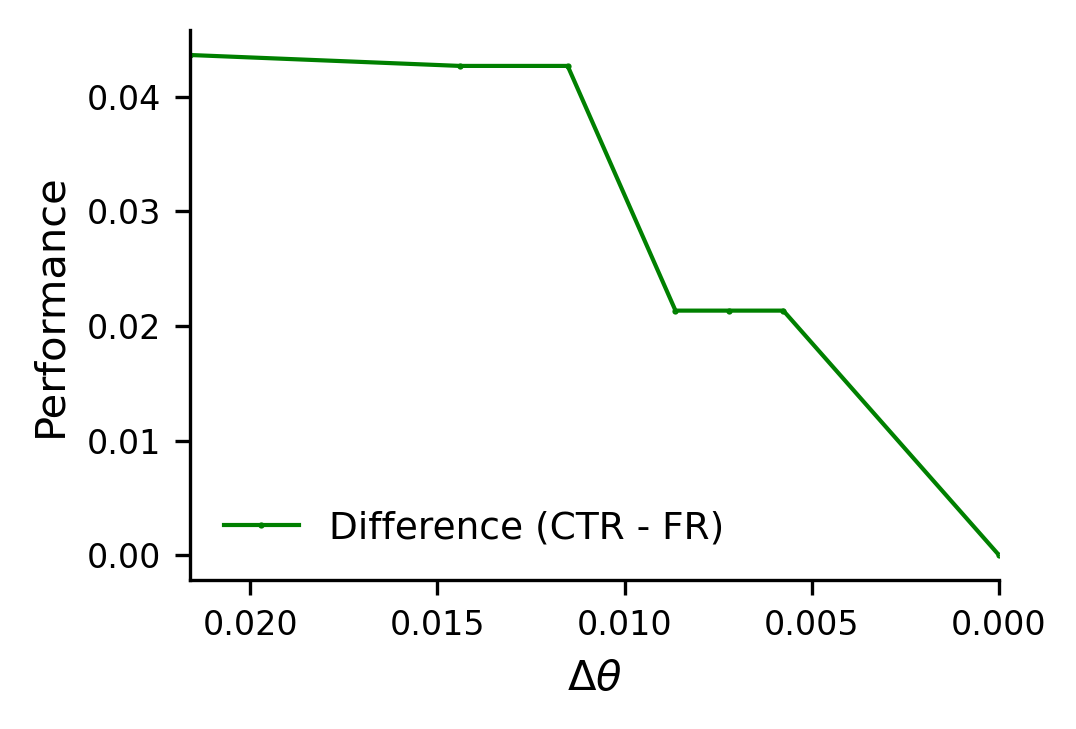

In [47]:
def snr_to_performance(snrval):
    dprime = np.sqrt(snrval)
    z = dprime / np.sqrt(2)
    perf = norm.cdf(z)
    return perf
    # return snrval

def plottings(x,y, label, color):
    mean_y = y.mean(axis=1)
    sem_y = y.std(axis=1, ddof=1) / np.sqrt(y.shape[1])

    # for trial_idx in range(y.shape[1]):
    #     ax.plot(x, y[:, trial_idx], lw=0.5, alpha=0.3)


    ax.plot(x*(360/neurons), mean_y, lw=1, marker='o', linestyle='-', label=label, color=color)
    # ax.fill_between(x, mean_y - sem_y, mean_y + sem_y, alpha=0.3, label="±1 SEM", color=color)


fig, ax = plt.subplots(figsize=(3.5, 2.5))  # good size for 1-column figure

temp = 0.02
eta = 0.0
sigma_theta = 0.0
# plottings(delta_final_ctr[TEMP_VALUES.index(temp),ETA_VALUES.index(eta),SIG_THETA_VALUES.index(sigma_theta)], snr_to_performance(snr_final_ctr[TEMP_VALUES.index(temp),ETA_VALUES.index(eta),SIG_THETA_VALUES.index(sigma_theta)]), label=f"CTR", color="blue")
# plottings(delta_final_fr[TEMP_VALUES.index(temp),ETA_VALUES.index(eta),SIG_THETA_VALUES.index(sigma_theta)], snr_to_performance(snr_final_fr[TEMP_VALUES.index(temp),ETA_VALUES.index(eta),SIG_THETA_VALUES.index(sigma_theta)]), label=f"FR", color="red")

# sigma_theta = 0.0
# plottings(delta_final_ctr[TEMP_VALUES.index(temp),ETA_VALUES.index(eta),SIG_THETA_VALUES.index(sigma_theta)], snr_to_performance(snr_final_ctr[TEMP_VALUES.index(temp),ETA_VALUES.index(eta),SIG_THETA_VALUES.index(sigma_theta)]), label=f"CTR (no noise)", color="cyan")
# plottings(delta_final_fr[TEMP_VALUES.index(temp),ETA_VALUES.index(eta),SIG_THETA_VALUES.index(sigma_theta)], snr_to_performance(snr_final_fr[TEMP_VALUES.index(temp),ETA_VALUES.index(eta),SIG_THETA_VALUES.index(sigma_theta)]), label=f"FR (no noise)", color="magenta")

# plot the difference between CTR and FR
difference = snr_to_performance(snr_final_ctr[TEMP_VALUES.index(temp),ETA_VALUES.index(eta),SIG_THETA_VALUES.index(sigma_theta)]) - snr_to_performance(snr_final_fr[TEMP_VALUES.index(temp),ETA_VALUES.index(eta),SIG_THETA_VALUES.index(sigma_theta)])
plottings(delta_final_ctr[TEMP_VALUES.index(temp),ETA_VALUES.index(eta),SIG_THETA_VALUES.index(sigma_theta)], difference, label="Difference (CTR - FR)", color="green")



plt.rcParams.update({
    "font.size": 9,
    "axes.labelsize": 10,
    "axes.titlesize": 10,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.dpi": 300,
    "lines.markersize": 0.5
})
ax.set_xlabel(r"$\Delta \theta$")
ax.set_ylabel("Performance")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# tighter x margins and layout
ax.margins(x=0)
ax.legend(frameon=False)
fig.tight_layout()
ax.invert_xaxis()
plt.show()

## Verification 

In [34]:
def get_bump(idir, num_neurons, sigma_input, amplitude):
    center_index_tensor = np.full(num_neurons, int(idir*num_neurons))

    sigma_idx = sigma_input * num_neurons                        # width in *index* units
    d0 = np.arange(0, (num_neurons//2)+1)
    bump_LUT = np.exp(-0.5 * (d0 / sigma_idx)**2)  # size ≈ N/2+1
    distances = np.arange(num_neurons)
    distances = np.abs(distances - center_index_tensor)
    distances = np.minimum(distances, num_neurons - distances)
    input_bump_profile = amplitude* bump_LUT[distances]
    return input_bump_profile


def calculate_R(state, N, T, Gen,ampar,rin):
    # Define R matrix which is (1-DJ)^-1 D/T    where D matrix is \partial(\sigma(h))/\partial h
    threshold_active_fraction = 0.1
    equilibrium_change = 200

    indices = np.arange(N)
    i_matrix = indices[:, None]      # shape (N, 1)
    j_matrix = indices[None, :]      # shape (1, N)
    diff = np.abs(i_matrix - j_matrix)
    diff = np.minimum(diff, N - diff)
    threshold = threshold_active_fraction * N / 2.0
    weights = (diff <= threshold).astype(float) / N
    np.fill_diagonal(weights, 0.0)

    R_matrices = np.zeros((Gen//equilibrium_change, N, N))
    for gen in range(Gen//equilibrium_change):
        start_gen = gen*equilibrium_change
        end_gen = (gen+1)*equilibrium_change
        mean_firing_rate = state[:, start_gen:end_gen].mean(axis=1)
        D_matrix = np.diag(mean_firing_rate * (1 - mean_firing_rate)/T)
        R_matrices[gen,:,:] = np.linalg.inv(np.eye(N) - rin*ampar*D_matrix @ weights) @ D_matrix*rin
    Mean_R_matrix = R_matrices.mean(axis=0)
    return Mean_R_matrix

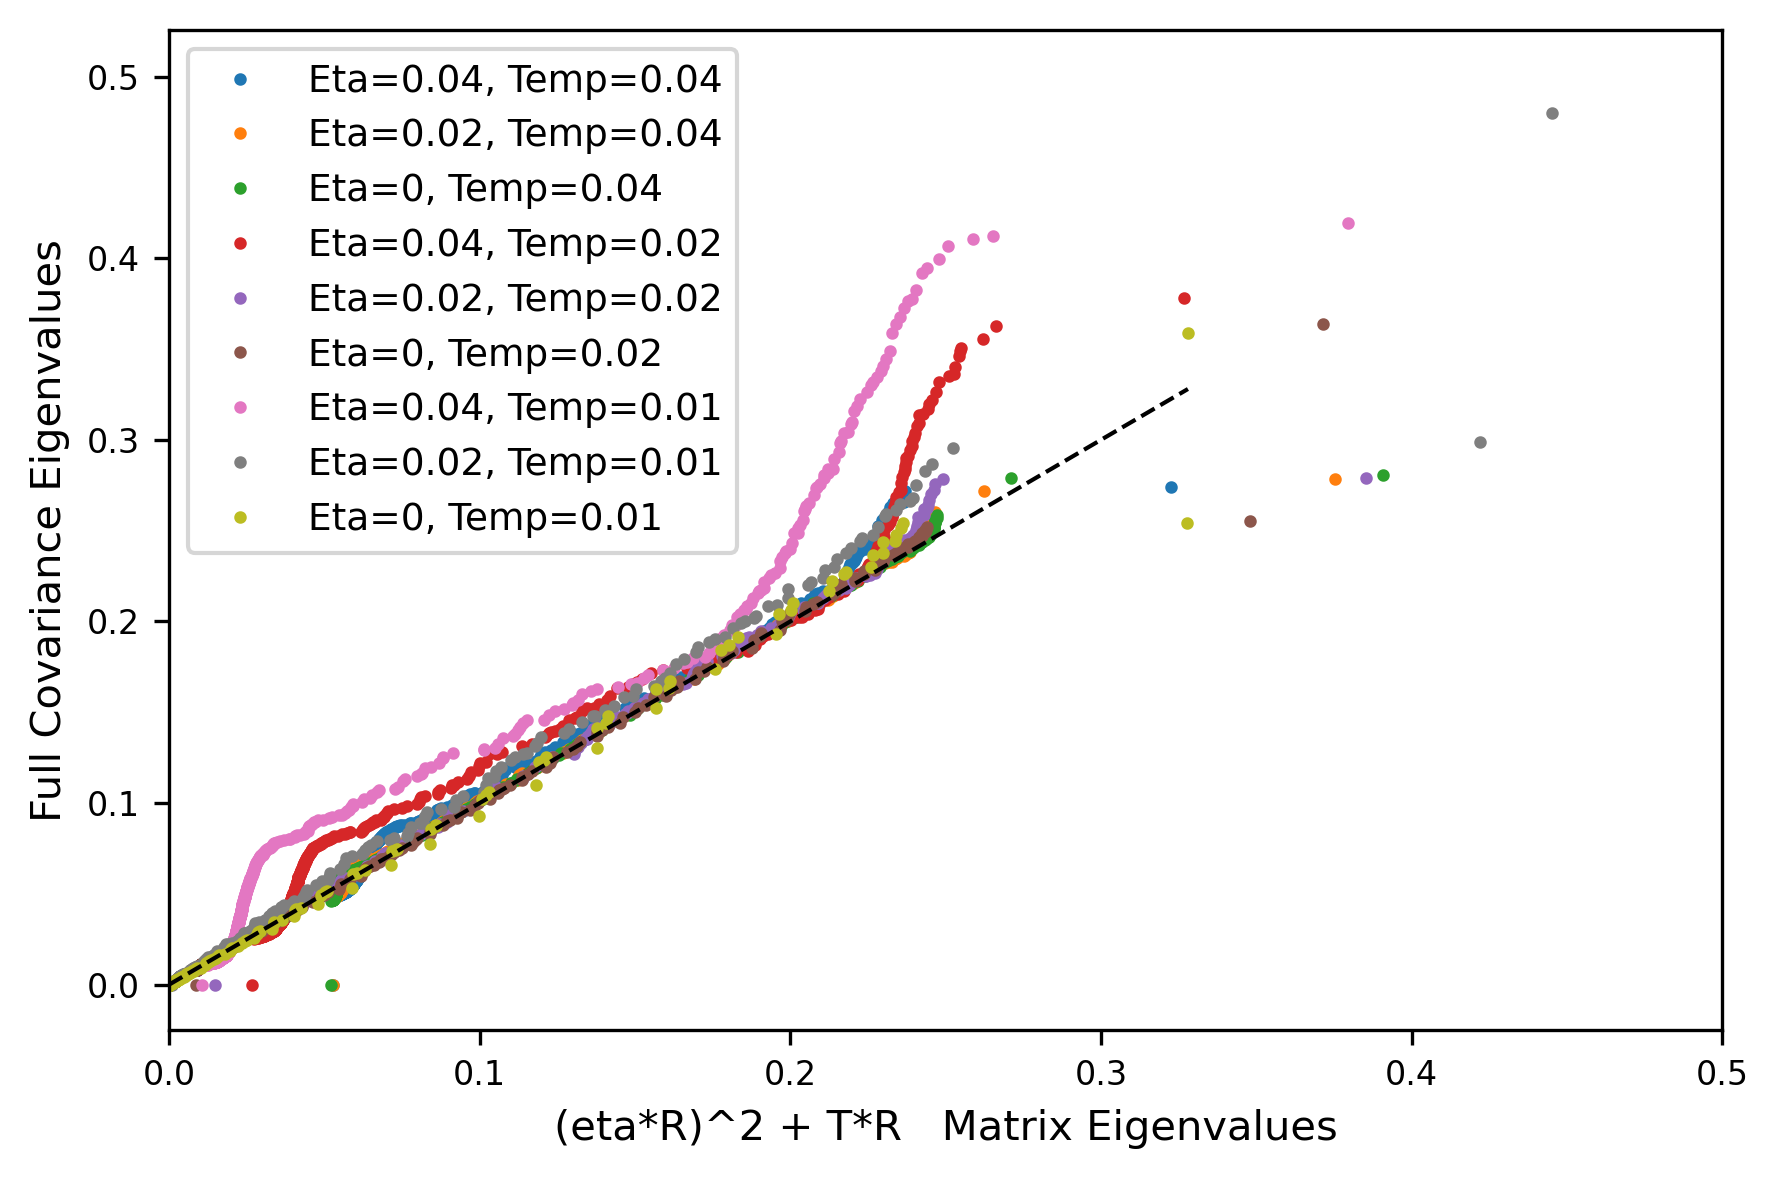

In [35]:
AMPAR = 0.64
RIN = 1.27


fig, ax = plt.subplots(figsize=(6, 4))
for TEMP in TEMP_VALUES[::-1]:
    for ETA in ETA_VALUES[::-1]:
        state_one_angle = tensors[AMPAR, RIN, TEMP, ETA][:,:,:,0]
        Neurons, Generations, Trials = state_one_angle.shape
        state_one_angle = state_one_angle.reshape((Neurons, -1))
        Generations = state_one_angle.shape[1]

        covariance_full = np.cov(state_one_angle)
        eigenvalues_full, eigenvectors_full = np.linalg.eigh(covariance_full)

        # Define R matrix which is D(1-DJ)^-1 where D matrix is \partial(\sigma(h))/\partial h
        Mean_R_matrix = calculate_R(state_one_angle, Neurons, TEMP, Generations, AMPAR, RIN)
        eigenvalues_r, eigenvectors_r = np.linalg.eigh(Mean_R_matrix)
        pred_full = (ETA*eigenvalues_r)**2 + eigenvalues_r*TEMP/((RIN))
        eig_r_predict = eigenvalues_r*TEMP
        predict = pred_full
        ax.plot(predict,eigenvalues_full, 'o', markersize=2, label=f'Eta={ETA}, Temp={TEMP}')
ax.plot([0, np.max(predict)], [0, np.max(predict)], 'k--', lw=1)
ax.set_ylabel("Full Covariance Eigenvalues")
ax.set_xlabel("(eta*R)^2 + T*R   Matrix Eigenvalues")
plt.xlim(0,0.5)
# plt.ylim(0,0.3)
plt.legend()
fig.tight_layout()
plt.show()

In [36]:
AMPAR = 0.64
RIN = 1.27

snr_actual = np.zeros((len(IDIR_VALUES), len(TEMP_VALUES), len(ETA_VALUES)))
snr_predicted = np.zeros((len(IDIR_VALUES), len(TEMP_VALUES), len(ETA_VALUES)))
for idir in range(1, len(IDIR_VALUES)-1):
    for TEMP in TEMP_VALUES[::-1]:
            for ETA in ETA_VALUES[::-1]:
                state_one_angle = tensors[AMPAR, RIN, TEMP, ETA][:,:,:,0]
                Neurons, Generations, Trials = state_one_angle.shape
                state_one_angle = state_one_angle.reshape((Neurons, -1))
                
                # FULL COVARIANCE
                covariance_full = np.cov(state_one_angle)
                eigenvalues_full, eigenvectors_full = np.linalg.eigh(covariance_full)

                # CALCULATE DELTA MU AND SNR             
                mu1 = tensors[AMPAR, RIN, TEMP, ETA][:,:,:,idir].reshape((Neurons, -1)).mean(axis=1) 
                mu2 = state_one_angle.mean(axis=1)
                delta_mu = mu1 - mu2
                snr = delta_mu.T @ np.linalg.pinv(covariance_full) @ delta_mu


                # PREDICITONS FOR R 
                Mean_R_matrix = calculate_R(state_one_angle, Neurons, TEMP, Generations, AMPAR, RIN)
                eigenvalues_r, eigenvectors_r = np.linalg.eigh(Mean_R_matrix)
                # PREDICTIONS FOR DMU
                bump = get_bump(IDIR_VALUES[0], Neurons, 0.05, 0.1)
                bump_dx  = get_bump(IDIR_VALUES[idir], Neurons, 0.05, 0.1)
                delta_x_bump = bump_dx - bump
                delta_mu_predict = AMPAR* Mean_R_matrix @ delta_x_bump
                
                ## PREDICTIONS FOR SNR
                # overlap_term = eigenvalues_r**2 * (eigenvectors_r.T @ delta_x_bump)**2
                # cov_eval = ((ETA*eigenvalues_r/TEMP)**2 + eigenvalues_r)
                # snr_predicted_eigenvalues = np.sum(overlap_term/cov_eval)

                # predicted_covariance = AMPAR*(ETA*Mean_R_matrix)@(ETA*Mean_R_matrix) + Mean_R_matrix*TEMP/(RIN**2 * AMPAR)
                predicted_covariance = (ETA*Mean_R_matrix)@(ETA*Mean_R_matrix) + Mean_R_matrix*TEMP/(RIN)

                snr_predicted_eigenvalues = delta_mu_predict.T @ np.linalg.pinv(predicted_covariance) @ delta_mu_predict
                
                snr_actual[idir-1, TEMP_VALUES.index(TEMP), ETA_VALUES.index(ETA)] = snr
                snr_predicted[idir-1, TEMP_VALUES.index(TEMP), ETA_VALUES.index(ETA)] = snr_predicted_eigenvalues


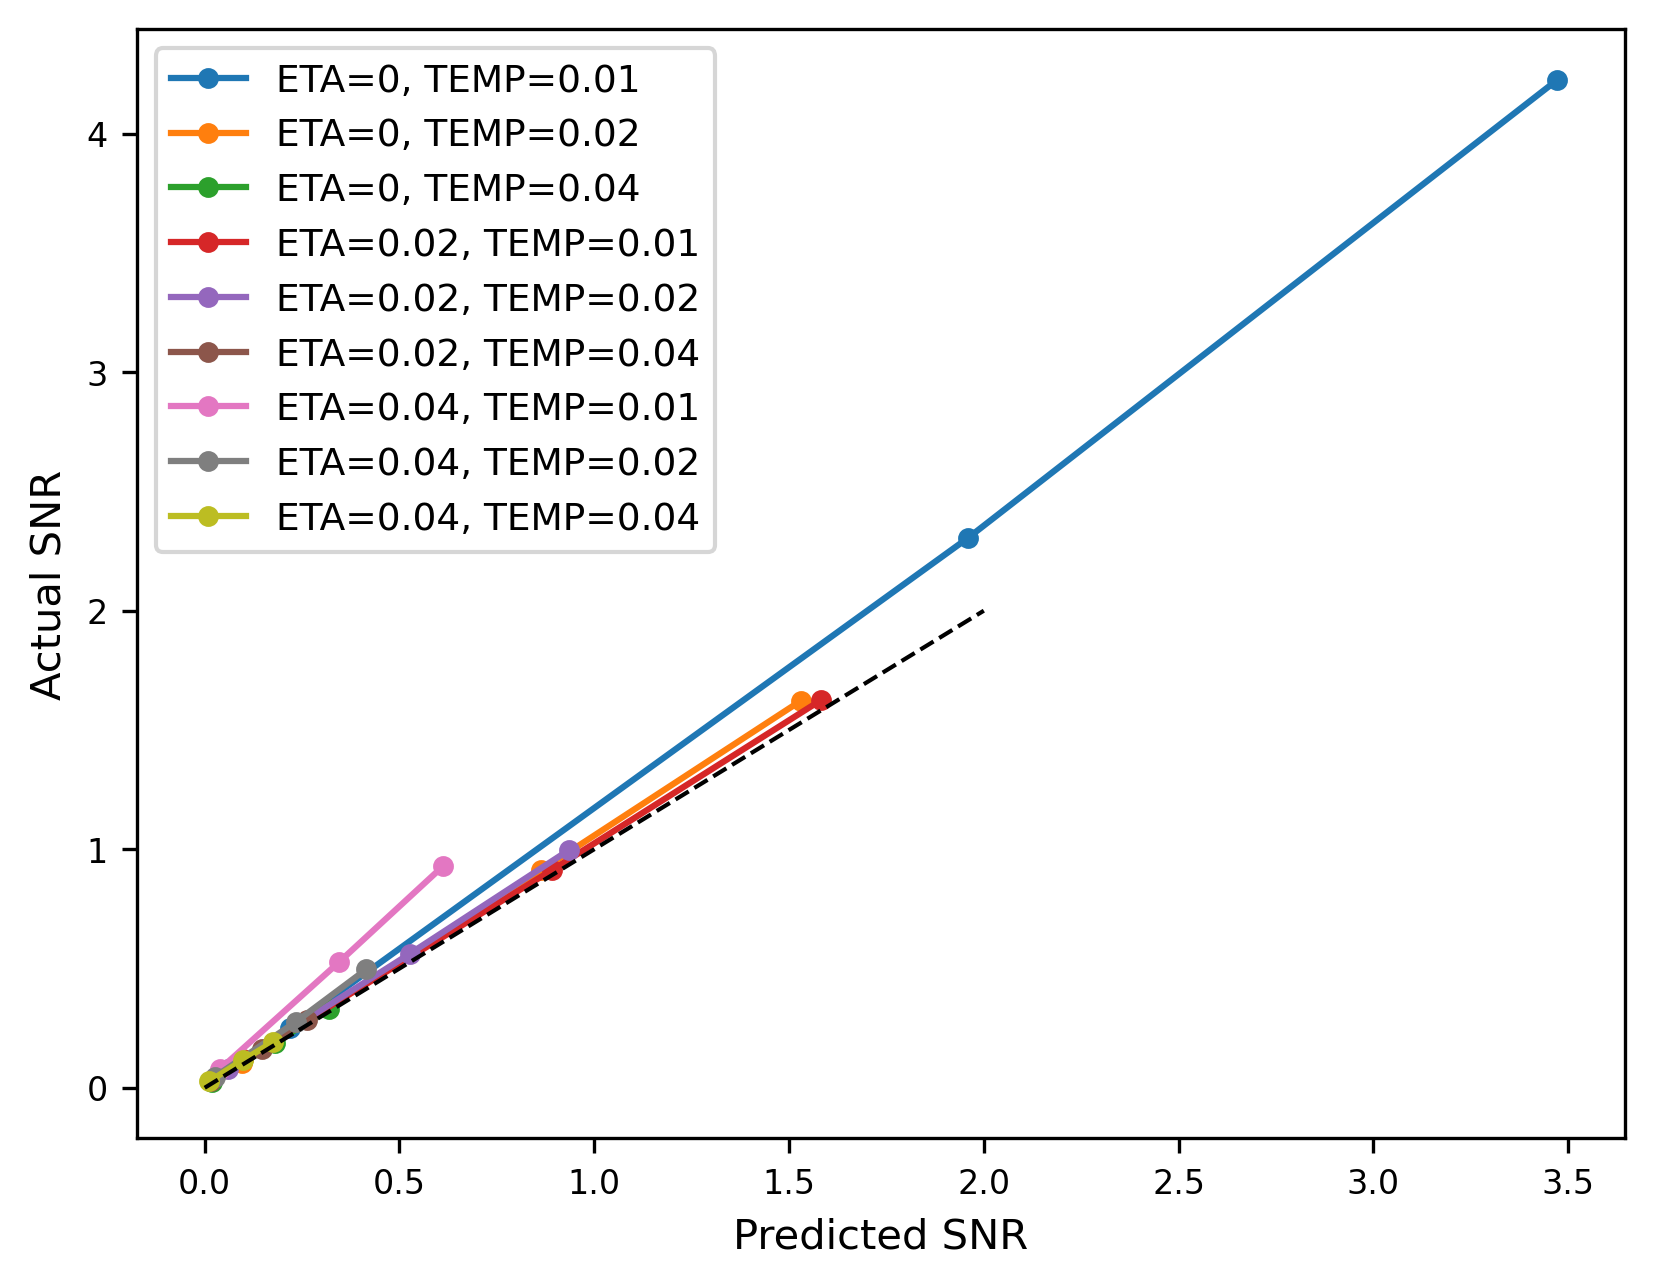

In [45]:
max_idir = len(IDIR_VALUES)-2
for eta in ETA_VALUES:
    for temp in TEMP_VALUES:
        # if temp==0.01 and eta==0.0:
        #     continue
        # if temp==0.01 and eta==0.04:
        #     continue
  
        plt.plot(snr_predicted[:max_idir,TEMP_VALUES.index(temp),ETA_VALUES.index(eta)].flatten(), snr_actual[:max_idir,TEMP_VALUES.index(temp),ETA_VALUES.index(eta)].flatten(), 'o-',markersize = 4, label=f'ETA={eta}, TEMP={temp}')
#marker size
plt.xlabel("Predicted SNR")
plt.ylabel("Actual SNR")
plt.plot([0,2], [0,2], 'k--', lw=1  )
# plt.xlim(0,10)
# plt.ylim(0,10)
plt.legend()
plt.show()

In [26]:
# Checking effect of food restriction on SNR


AMPAR = 1.0
RIN = 1.0
Neurons = 500

snr_actual = np.zeros((len(IDIR_VALUES), len(TEMP_VALUES), len(ETA_VALUES)))
snr_predicted_CTR = np.zeros((len(IDIR_VALUES), len(TEMP_VALUES), len(ETA_VALUES)))
for idir in range(1, len(IDIR_VALUES)):
    bump = get_bump(IDIR_VALUES[0], Neurons, 0.05, 0.1)
    bump_dx  = get_bump(IDIR_VALUES[idir], Neurons, 0.05, 0.1)
    for TEMP in TEMP_VALUES[::-1]:
            for ETA in ETA_VALUES[::-1]:
                state_one_angle = tensors[AMPAR, RIN, TEMP, ETA][:,:,:,0]
                Neurons, Generations, Trials = state_one_angle.shape
                state_one_angle = state_one_angle.reshape((Neurons, -1))

                # PREDICITONS FOR R 
                Mean_R_matrix = calculate_R(state_one_angle, Neurons, TEMP, Generations, AMPAR,RIN)
                eigenvalues_r, eigenvectors_r = np.linalg.eigh(Mean_R_matrix)
                # PREDICTIONS FOR DMU

                delta_x_bump = bump_dx - bump
                delta_mu_predict = AMPAR*Mean_R_matrix @ delta_x_bump

                predicted_covariance = (ETA*Mean_R_matrix)@(ETA*Mean_R_matrix) + Mean_R_matrix*TEMP
                snr_predicted = delta_mu_predict.T @ np.linalg.pinv(predicted_covariance) @ delta_mu_predict
                snr_predicted_CTR[idir-1, TEMP_VALUES.index(TEMP), ETA_VALUES.index(ETA)] = snr_predicted
AMPAR = 0.64
RIN = 1.27

snr_actual = np.zeros((len(IDIR_VALUES), len(TEMP_VALUES), len(ETA_VALUES)))
snr_predicted_FR = np.zeros((len(IDIR_VALUES), len(TEMP_VALUES), len(ETA_VALUES)))
for idir in range(1, len(IDIR_VALUES)):
    bump = get_bump(IDIR_VALUES[0], Neurons, 0.05, 0.1)
    bump_dx  = get_bump(IDIR_VALUES[idir], Neurons, 0.05, 0.1)
    for TEMP in TEMP_VALUES[::-1]:
            for ETA in ETA_VALUES[::-1]:
                state_one_angle = tensors[AMPAR, RIN, TEMP, ETA][:,:,:,0]
                Neurons, Generations, Trials = state_one_angle.shape
                state_one_angle = state_one_angle.reshape((Neurons, -1))

                # PREDICITONS FOR R 
                Mean_R_matrix = calculate_R(state_one_angle, Neurons, TEMP, Generations, AMPAR,RIN)
                eigenvalues_r, eigenvectors_r = np.linalg.eigh(Mean_R_matrix)
                # PREDICTIONS FOR DMU
                delta_x_bump = bump_dx - bump
                delta_mu_predict = AMPAR*Mean_R_matrix @ delta_x_bump

                predicted_covariance = (ETA*Mean_R_matrix)@(ETA*Mean_R_matrix) + Mean_R_matrix*TEMP
                snr_predicted = delta_mu_predict.T @ np.linalg.pinv(predicted_covariance) @ delta_mu_predict
                snr_predicted_FR[idir-1, TEMP_VALUES.index(TEMP), ETA_VALUES.index(ETA)] = snr_predicted

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 500 is different from 100)

/tmp/ipykernel_3456/4066449938.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(IDIR_VALUES, snr_predicted_FR[:max_idir,TEMP_VALUES.index(temp),ETA_VALUES.index(eta)].flatten()/snr_predicted_CTR[:max_idir,TEMP_VALUES.index(temp),ETA_VALUES.index(eta)].flatten(), 'o-',markersize = 4, label=f'ETA={eta}, TEMP={temp}')


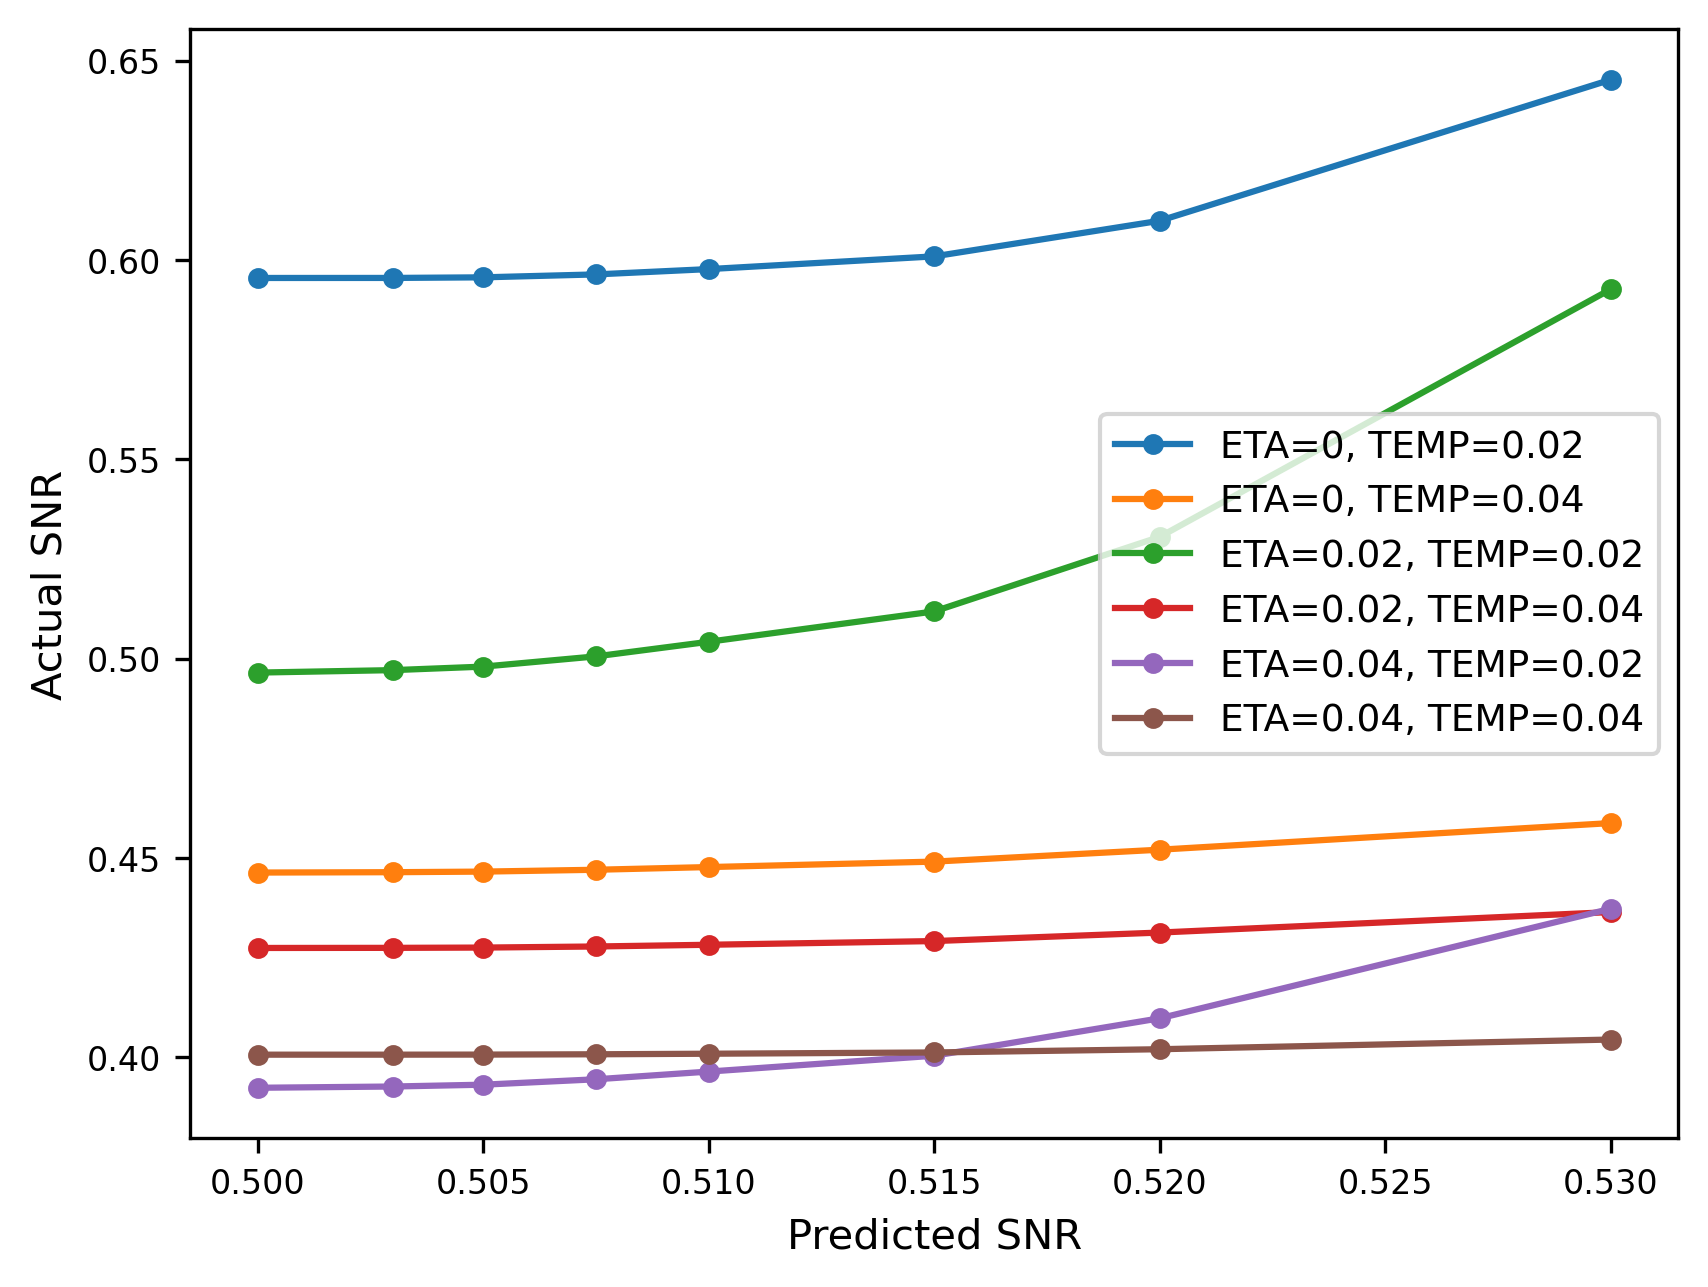

In [150]:
max_idir = len(IDIR_VALUES)
for eta in ETA_VALUES:
    for temp in TEMP_VALUES:
        plt.plot(IDIR_VALUES, snr_predicted_FR[:max_idir,TEMP_VALUES.index(temp),ETA_VALUES.index(eta)].flatten()/snr_predicted_CTR[:max_idir,TEMP_VALUES.index(temp),ETA_VALUES.index(eta)].flatten(), 'o-',markersize = 4, label=f'ETA={eta}, TEMP={temp}')
#marker size
plt.xlabel("Predicted SNR")
plt.ylabel("Actual SNR")

plt.legend()
plt.show()